# Analyze July Fourth Spike

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_account = pd.read_csv('../challenge_data/account_dat.csv')
df_app = pd.read_csv('../challenge_data/app_dat.csv')
df_category = pd.read_csv('../challenge_data/category_ref.csv')
df_device = pd.read_csv('../challenge_data/device_ref.csv')
df_in_app = pd.read_csv('../challenge_data/in-app_dat.csv')
df_transaction = pd.read_csv('../challenge_data/transaction_dat.csv')

In [3]:
df_account['create_dt'] = pd.to_datetime(df_account['create_dt'])
df_transaction['create_dt'] = pd.to_datetime(df_transaction['create_dt'])

In [4]:
df_in_app_denorm = df_in_app.join(df_app.set_index('content_id'), on='parent_app_content_id')\
                .join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_in_app_denorm.head()

,parent_app_content_id,content_id,type,app_name,category_id,device_id,category_name,device_name
0,d2bde35599e0dae9,227227a77c59809b,consumable,lactantem prevailing,Z-1,3,Games,Both
1,d2bde35599e0dae9,41ac2362a2600185,consumable,lactantem prevailing,Z-1,3,Games,Both
2,d2bde35599e0dae9,64a8e16f030bb611,consumable,lactantem prevailing,Z-1,3,Games,Both
3,d2bde35599e0dae9,2c8ba424183afa7c,consumable,lactantem prevailing,Z-1,3,Games,Both
4,d2bde35599e0dae9,b4c42fa5cc420f7b,consumable,lactantem prevailing,Z-1,3,Games,Both


In [5]:
df_app_denorm = df_app.join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_app_denorm['type'] = 'download_only'
df_app_denorm.head()

,app_name,content_id,category_id,device_id,category_name,device_name,type
0,half-slouched having,22dfac9721b899cb,Y-8,3,Photos & Videos,Both,download_only
1,lift whale-ships,7c645810cd7f166e,M-7,3,Utilities,Both,download_only
2,mightily community,c495bcb878faffaa,Y-8,2,Photos & Videos,iPad,download_only
3,session: too--shall,4e683dcd461cdd22,Y-8,1,Photos & Videos,iPhone,download_only
4,That Zoology,6473dd29a2badbf1,Y-8,3,Photos & Videos,Both,download_only


In [6]:
cols_app = ['app_name', 'content_id', 'type', 'category_name', 'device_name']
df_app_all = pd.concat([df_in_app_denorm[cols_app],
                        df_app_denorm[cols_app]])
df_app_all

,app_name,content_id,type,category_name,device_name
0,lactantem prevailing,227227a77c59809b,consumable,Games,Both
1,lactantem prevailing,41ac2362a2600185,consumable,Games,Both
2,lactantem prevailing,64a8e16f030bb611,consumable,Games,Both
3,lactantem prevailing,2c8ba424183afa7c,consumable,Games,Both
4,lactantem prevailing,b4c42fa5cc420f7b,consumable,Games,Both
...,...,...,...,...,...
995,animals nights--do,71cc78b6addcdc63,download_only,Entertainment,Both
996,meeting-house? respond,42e45e59e6d3dcf1,download_only,Photos & Videos,Both
997,--SIBBALD'S occupation,d862535438d4314c,download_only,Utilities,Both
998,cylinders vain!,07d53efa8e531e15,download_only,Photos & Videos,Both


In [7]:
df_trn_denorm = df_transaction.join(df_device.set_index('device_id'), on='device_id')\
                    .join(df_account.set_index('acct_id'), on='acct_id', lsuffix='_transaction', rsuffix='_acct')

# fill accounts that cannot join to payment_type
df_trn_denorm['payment_type'] = df_trn_denorm['payment_type'].fillna('unknown')

In [8]:
df_wide = df_trn_denorm.join(df_app_all.drop(columns=['device_name'])\
                             .set_index('content_id'), on='content_id')

# omit 'unknown' payment_type
df_wide = df_wide[df_wide['payment_type'] != 'unknown']

# create day_of_week name
df_wide['day_of_week_num'] = df_wide['create_dt_transaction'].dt.weekday
df_wide['day_of_week'] = df_wide['create_dt_transaction'].dt.day_name()

### Plot Time Series

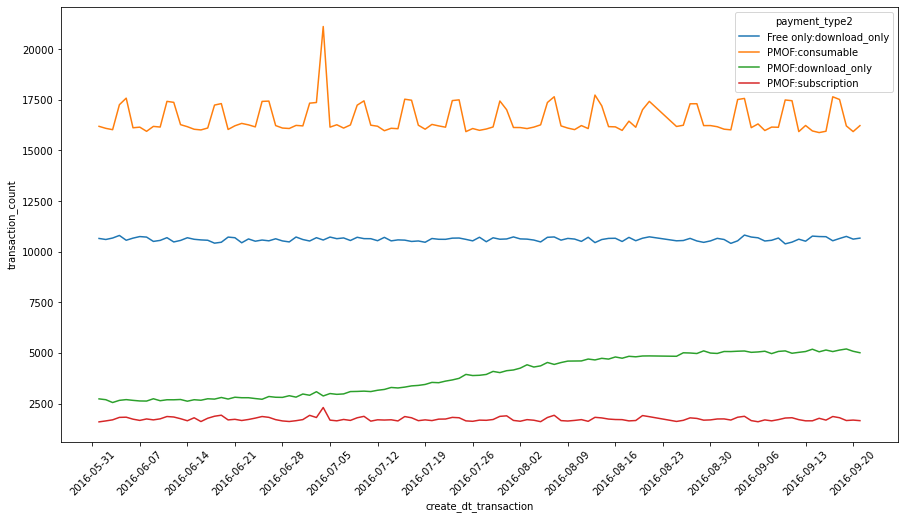

In [9]:
df_wide['payment_type2'] = df_wide['payment_type'] + ':' + df_wide['type']

df_wide_trn = df_wide.groupby(by=['create_dt_transaction','day_of_week_num',
                                  'day_of_week','payment_type2'], as_index=False)\
                        .agg(trn_cnt=('content_id', 'count'),
                             revenue=('price', 'sum'),
                             acct_cnt=('acct_id', 'nunique'))
                    

df_wide_trn['price_per_trn'] = df_wide_trn['revenue']/df_wide_trn['trn_cnt']
df_wide_trn['trn_per_acct'] = df_wide_trn['trn_cnt']/df_wide_trn['acct_cnt']
    
plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='trn_cnt', hue='payment_type2', 
             data=df_wide_trn)
ax.set_ylabel('transaction_count')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

In [10]:
# save output to csv for plotting in visualization program


df_wide_trn_pivot = df_wide_trn.pivot(index='create_dt_transaction', columns='payment_type2', values='trn_per_acct')
df_wide_trn_pivot.reset_index(inplace=True)

df_wide_trn_pivot.to_csv("time_series_trn_acct.csv", index=False)

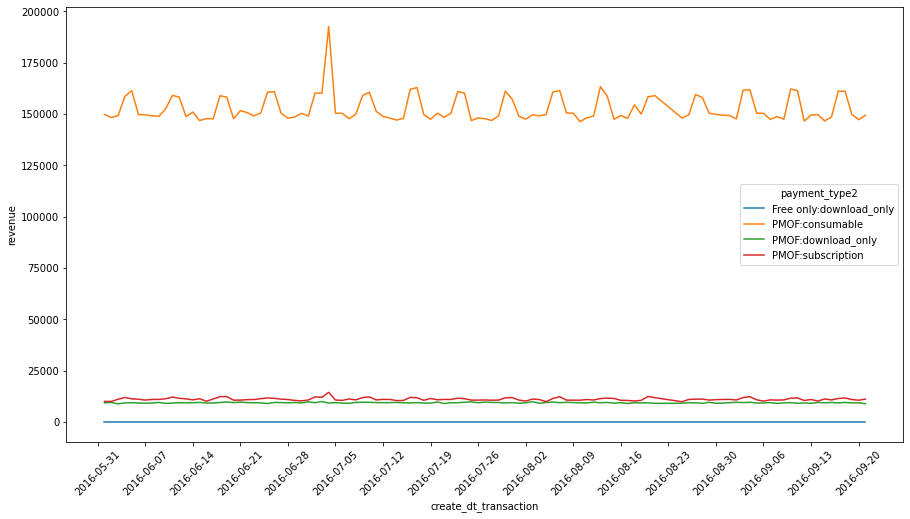

In [11]:
plt.figure(figsize=(15,8))
plt.xticks(rotation = 45)
ax = sns.lineplot(x='create_dt_transaction', y='revenue', hue='payment_type2', 
             data=df_wide_trn)
ax.set_ylabel('revenue')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

In [12]:
df_wide_trn['price_per_trn'] = df_wide_trn['revenue']/df_wide_trn['trn_cnt']
df_wide_trn['trn_per_acct'] = df_wide_trn['trn_cnt']/df_wide_trn['acct_cnt']

In [13]:
df_wide_trn[df_wide_trn['create_dt_transaction'] > '2016-07-01'].head(15)

,create_dt_transaction,day_of_week_num,day_of_week,payment_type2,trn_cnt,revenue,acct_cnt,price_per_trn,trn_per_acct
124,2016-07-02,5,Saturday,Free only:download_only,10530,0.00,7541,0.000000,1.396367
125,2016-07-02,5,Saturday,PMOF:consumable,17335,160303.65,9906,9.247398,1.749950
126,2016-07-02,5,Saturday,PMOF:download_only,2915,9345.37,2678,3.205959,1.088499
127,2016-07-02,5,Saturday,PMOF:subscription,1923,12176.77,1751,6.332174,1.098230
128,2016-07-03,6,Sunday,Free only:download_only,10694,0.00,7608,0.000000,1.405626
129,2016-07-03,6,Sunday,PMOF:consumable,17368,160128.32,9904,9.219733,1.753635
130,2016-07-03,6,Sunday,PMOF:download_only,3090,9927.77,2793,3.212871,1.106337
131,2016-07-03,6,Sunday,PMOF:subscription,1816,11968.84,1622,6.590771,1.119605
132,2016-07-04,0,Monday,Free only:download_only,10579,0.00,7500,0.000000,1.410533
133,2016-07-04,0,Monday,PMOF:consumable,21119,192647.81,10989,9.122014,1.921831


In [18]:
df_wo_j4_mean = df_wide_trn[df_wide_trn['create_dt_transaction'] != '2016-07-04']\
                .groupby(by=['day_of_week', 'payment_type2'], as_index=False)\
                .agg(mean_trn_cnt=('trn_cnt', 'mean'),
                     mean_rev=('revenue', 'mean'),
                     mean_price_per_trn=('price_per_trn', 'mean'),
                     mean_trn_per_acct=('trn_per_acct', 'mean'))


df_wo_j4_mean_p = df_wo_j4_mean.pivot(index='day_of_week', columns='payment_type2', values='mean_trn_per_acct')
df_wo_j4_mean_p.to_csv('dow_trn_per_acct.csv')
df_wo_j4_mean_p

payment_type2,Free only:download_only,PMOF:consumable,PMOF:download_only,PMOF:subscription
day_of_week,,,,
Friday,1.394999,1.712646,1.136047,1.107418
Monday,1.395367,1.712073,1.138296,1.109301
Saturday,1.393443,1.765442,1.133512,1.102478
Sunday,1.395567,1.764039,1.135165,1.107784
Thursday,1.396634,1.713176,1.133041,1.101998
Tuesday,1.396074,1.712613,1.134594,1.100628
Wednesday,1.398261,1.710632,1.135495,1.102761


In [19]:
df_wo_j4_mean_p2 = df_wo_j4_mean.pivot(index='day_of_week', columns='payment_type2', values='mean_price_per_trn')
df_wo_j4_mean_p2.to_csv('dow_price_per_trn.csv')
df_wo_j4_mean_p2

payment_type2,Free only:download_only,PMOF:consumable,PMOF:download_only,PMOF:subscription
day_of_week,,,,
Friday,0.0,9.250983,2.572329,6.327678
Monday,0.0,9.236206,2.528382,6.384193
Saturday,0.0,9.222467,2.558085,6.366526
Sunday,0.0,9.192632,2.553729,6.374050
Thursday,0.0,9.207703,2.576133,6.274281
Tuesday,0.0,9.244080,2.553171,6.385816
Wednesday,0.0,9.245307,2.602828,6.351329


In [16]:
# only july 4th
df_j4_mean = df_wide_trn[df_wide_trn['create_dt_transaction'] == '2016-07-04']\
                .groupby(by=['day_of_week', 'payment_type2'], as_index=False)\
                .agg(mean_trn_cnt=('trn_cnt', 'mean'),
                     mean_rev=('revenue', 'mean'),
                     mean_price_per_trn=('price_per_trn', 'mean'),
                     mean_trn_per_acct=('trn_per_acct', 'mean'))
df_j4_mean.pivot(index='day_of_week', columns='payment_type2', values='mean_trn_per_acct')

payment_type2,Free only:download_only,PMOF:consumable,PMOF:download_only,PMOF:subscription
day_of_week,,,,
Monday,1.410533,1.921831,1.098398,1.120815


In [17]:
df_j4_mean.pivot(index='day_of_week', columns='payment_type2', values='mean_price_per_trn')

payment_type2,Free only:download_only,PMOF:consumable,PMOF:download_only,PMOF:subscription
day_of_week,,,,
Monday,0.0,9.122014,3.181615,6.227662
